In [22]:
"""
https://www.kaggle.com/marcogorelli/criskiev-s-distances-more-estimators-groupkfold
"""

'\nhttps://www.kaggle.com/marcogorelli/criskiev-s-distances-more-estimators-groupkfold\n'

In [33]:
%matplotlib inline

import pandas as pd
import numpy as np
import os

import math
import gc
import copy

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import lightgbm as lgb

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

In [34]:
DATA_PATH = '/home/jovyan/work/Molecular_Properties'
SUBMISSIONS_PATH = './'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [35]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}/train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [36]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [37]:
submission_csv = pd.read_csv(f'{DATA_PATH}/sample_submission.csv', index_col='id')

In [38]:
test_csv = pd.read_csv(f'{DATA_PATH}/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [39]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}/structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [40]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

In [41]:
#Build Distance Dataset
def build_type_dataframes(base, structures, coupling_type):
    #base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures


In [42]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [43]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [44]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [45]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

In [46]:
def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

In [47]:
def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [48]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [49]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [50]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    #join_df_type = join_df[join_df["type"] == coupling_type]
    
    #join_df = join_df.drop(['molecule_name',	'atom_index_0', 'atom_index_1','type', 'bond_indices'], axis = 1)
    
    #if 'scalar_coupling_constant' in join_df:
    #    join_df = join_df.drop(['scalar_coupling_constant'], axis = 1)
    
    #full = full.merge(join_df, how = 'left', on = 'id')
    
    return full

In [51]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [52]:
#Check LightGBM with the smallest type
full_train = build_couple_dataframe(train_csv, structures_csv, 
                                    #df_train, 
                                    '1JHN', n_atoms=10)
full_test = build_couple_dataframe(test_csv, structures_csv, 
                                   #df_test, 
                                   '1JHN', n_atoms=10)
print(full_train.shape)
print(full_test.shape)

(4658147, 82)
(2505542, 81)


In [53]:
full_train.head()

,id,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,type_2,type_3,type_4,type_5,type_6,type_7,type_8,type_9,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,0,1,1,0,1JHC,84.807602,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001,1JHC,1JHC,1JHC,NaN,NaN,NaN,NaN,NaN,1,1,1,0,0,0,0,0,1.011731,-0.540815,-0.523814,NaN,NaN,NaN,NaN,NaN,1.463751,1.447527,1.437933,NaN,NaN,NaN,NaN,NaN,0.000277,-0.876644,0.906397,NaN,NaN,NaN,NaN,NaN,1.091953,1.783120,1.091952,1.783147,1.091946,1.783158,1.783157,1.091948,1.783148,1.783148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,1,2,2JHH,-11.257000,0.002150,-0.006031,0.001976,1.011731,1.463751,0.000277,2JHH,2JHH,2JHH,NaN,NaN,NaN,NaN,NaN,6,1,1,0,0,0,0,0,-0.012698,-0.523814,-0.540815,NaN,NaN,NaN,NaN,NaN,1.085804,1.437933,1.447527,NaN,NaN,NaN,NaN,NaN,0.008001,0.906397,-0.876644,NaN,NaN,NaN,NaN,NaN,1.783120,1.091953,1.091952,1.783157,1.783148,1.091948,1.783147,1.783158,1.091946,1.783148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2,1,1,3,2JHH,-11.254800,0.002150,-0.006031,0.001976,-0.540815,1.447527,-0.876644,2JHH,2JHH,2JHH,NaN,NaN,NaN,NaN,NaN,6,1,1,0,0,0,0,0,-0.012698,1.011731,-0.523814,NaN,NaN,NaN,NaN,NaN,1.085804,1.463751,1.437933,NaN,NaN,NaN,NaN,NaN,0.008001,0.000277,0.906397,NaN,NaN,NaN,NaN,NaN,1.783147,1.091953,1.091946,1.783120,1.783158,1.091952,1.783157,1.783148,1.091948,1.783148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3,1,1,4,2JHH,-11.254300,0.002150,-0.006031,0.001976,-0.523814,1.437933,0.906397,2JHH,2JHH,2JHH,NaN,NaN,NaN,NaN,NaN,6,1,1,0,0,0,0,0,-0.012698,1.011731,-0.540815,NaN,NaN,NaN,NaN,NaN,1.085804,1.463751,1.447527,NaN,NaN,NaN,NaN,NaN,0.008001,0.000277,-0.876644,NaN,NaN,NaN,NaN,NaN,1.783157,1.091953,1.091948,1.783120,1.783148,1.091952,1.783147,1.783148,1.091946,1.783158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,1,2,0,1JHC,84.807404,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001,1JHC,1JHC,1JHC,NaN,NaN,NaN,NaN,NaN,1,1,1,0,0,0,0,0,0.002150,-0.523814,-0.540815,NaN,NaN,NaN,NaN,NaN,-0.006031,1.437933,1.447527,NaN,NaN,NaN,NaN,NaN,0.001976,0.906397,-0.876644,NaN,NaN,NaN,NaN,NaN,1.091952,1.783120,1.091953,1.783148,1.091948,1.783157,1.783158,1.091946,1.783147,1.783148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
full_test.head()

,id,molecule_index,atom_index_0,atom_index_1,type,x_0,y_0,z_0,x_1,y_1,z_1,type_2,type_3,type_4,type_5,type_6,type_7,type_8,type_9,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,4658147,4,2,0,2JHC,-1.661639,0.0,1.0,0.599540,0.0,1.0,2JHC,2JHC,NaN,NaN,NaN,NaN,NaN,NaN,6,1,0,0,0,0,0,0,-0.59954,1.661639,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.261178,1.062099,1.199079,3.323277,1.062099,2.261178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4658148,4,2,1,1JHC,-1.661639,0.0,1.0,-0.599540,0.0,1.0,1JHC,1JHC,NaN,NaN,NaN,NaN,NaN,NaN,6,1,0,0,0,0,0,0,0.59954,1.661639,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.062099,2.261178,1.199079,3.323277,2.261178,1.062099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4658149,4,2,3,3JHH,-1.661639,0.0,1.0,1.661639,0.0,1.0,3JHH,3JHH,NaN,NaN,NaN,NaN,NaN,NaN,6,6,0,0,0,0,0,0,0.59954,-0.599540,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.323277,2.261178,1.062099,1.062099,2.261178,1.199079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4658150,4,3,0,1JHC,1.661639,0.0,1.0,0.599540,0.0,1.0,1JHC,1JHC,NaN,NaN,NaN,NaN,NaN,NaN,6,1,0,0,0,0,0,0,-0.59954,-1.661639,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.062099,2.261178,1.199079,3.323277,2.261178,1.062099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4658151,4,3,1,2JHC,1.661639,0.0,1.0,-0.599540,0.0,1.0,2JHC,2JHC,NaN,NaN,NaN,NaN,NaN,NaN,6,1,0,0,0,0,0,0,0.59954,-1.661639,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.261178,1.062099,1.199079,3.323277,1.062099,2.261178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df = take_n_atoms(full_train, 7)
# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')

In [56]:
X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y_data = df['scalar_coupling_constant'].values.astype('float32')

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((3726517, 23), (931630, 23), (3726517,), (931630,))

In [85]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
LGB_PARAMS = {
    'objective': 'huber',
    'metric': 'mae',
    'verbosity': -1,
    'min_data_in_leaf' : 20,  
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 512,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [86]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)    
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data, full.molecule_index.values

In [87]:
#full = build_couple_dataframe(train_csv, structures_csv, coupling_type, n_atoms=10)

In [88]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data, groups = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _, __ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')
    train_pred = np.zeros(X_data.shape[0], dtype='float32')
    
    print(f'shape of the train data is: {X_data.shape}')
    
    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = GroupKFold(n_splits=n_splits)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data, groups=groups)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=20000, _jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        train_pred += model.predict(X_data) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    test_csv.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant_pred'] = y_pred
    train_csv.loc[train_csv['type'] == coupling_type, 'scalar_coupling_constant_pred'] = train_pred
    return cv_score

In [89]:
#df_train = pd.read_csv("df_train.csv")
#df_test = pd.read_csv("df_test.csv")

In [91]:
model_params = {
    '1JHN': 10
    #,
    #'1JHC': 10
    #,
    #'2JHH': 9,
    #'2JHN': 9,
    #'2JHC': 9,
    #'3JHH': 9,
    #'3JHC': 10,
    #'3JHN': 10
}
N_FOLDS = 5
submission = submission_csv.copy()
train = train_csv.copy()


cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')
shape of the train data is: (4658147, 38)
Training until validation scores don't improve for 200 rounds.
[100]	traini

ValueError: shape mismatch: value array of shape (2505542,) could not be broadcast to indexing result of shape (24195,)

In [ ]:
train_csv['scalar_coupling_constant_pred'].describe()

In [ ]:
new = pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})
new

In [202]:
submission = submission.rename(columns={'scalar_coupling_constant': 'scalar_coupling_constant_pred'})

In [204]:
submission.head()

,scalar_coupling_constant_pred
id,
4658147,20.523109
4658148,149.976395
4658149,9.753801
4658150,149.976395
4658151,20.523109


In [160]:
train_csv.to_csv('criskiev_pred_train.csv', index = False)
test_csv.to_csv('criskiev_pred_test.csv', index = False)

In [21]:
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")

In [ ]:
#df_train = df_train[df_train['type'] == "1JHN"]
#df_test = df_test[df_test['type'] == "1JHN"]

In [ ]:
#train_csv = train_csv[train_csv['type'] == "1JHN"]
#test_csv = test_csv[test_csv['type'] == "1JHN"]

In [203]:
df_train = df_train.merge(train_csv[['id', 'scalar_coupling_constant_pred']], on = 'id')
#df_test = df_test.merge(test_csv[['id', 'scalar_coupling_constant_pred']], on = 'id')

In [206]:
df_test = df_test.merge(submission, on = 'id')

In [212]:
df_train[['scalar_coupling_constant_pred']].describe()

,scalar_coupling_constant_pred
count,4.658154e+06
mean,1.592149e+01
std,3.493937e+01
min,-3.490760e+01
25%,-2.511007e-01
50%,2.280383e+00
75%,7.380909e+00
max,2.047858e+02


In [ ]:
#Check LightGBM with the smallest type
full_train = build_couple_dataframe(train_csv, structures_csv, df_train, '1JHN', n_atoms=10)
full_test = build_couple_dataframe(test_csv, structures_csv, df_test, '1JHN', n_atoms=10)
print(full_train.shape)
print(full_test.shape)

In [386]:
full_train.head()

,id,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant,x_0_x,y_0_x,z_0_x,x_1_x,y_1_x,z_1_x,type_2,type_3,type_4,type_5,type_6,type_7,type_8,type_9,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,...,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff,number_of_bonds_molecule_type,atom_1_couples_type_count,atom_0_couples_type_count,C,H,N,atom_count,sum_electronegat_by_molecule,atom_index_closest_0,dist_y.1,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,1,1,0,1JHC,84.807602,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001,1JHC,1JHC,1JHC,NaN,NaN,NaN,NaN,NaN,1,1,1,0,0,0,0,0,1.011731,-0.540815,-0.523814,NaN,NaN,NaN,NaN,NaN,1.463751,1.447527,1.437933,NaN,NaN,NaN,NaN,NaN,0.000277,-0.876644,0.906397,NaN,NaN,NaN,NaN,NaN,1.091953,1.783120,1.091952,1.783147,1.091946,1.783158,1.783157,1.091948,...,1.474738,1.783157,0.691204,1.632998,1.091953,0.000000,1.000000,0.345594,-0.746359,0.316492,1.091950,-0.000003,0.999997,1.091953,0.000000,1.000000,1.091946,-0.000007,0.999994,0.000003,-1.091950,0.000003,1.091950,1.091946,-0.000007,0.999994,0.000003,-1.091950,0.000003,-1.091950,1.091950,-0.000003,0.999997,1.091953,1.091946,0.000003,-1.091950,4,4,1,1.0,4.0,0.0,5,11.35,0,1.091953,-0.012698,1.085804,0.008001,3,1.091946,-0.540815,1.447527,-0.876644,1.091953,1.091946,0.333335,-1.000006,-0.333337
1,1,1,1,2,2JHH,-11.257000,0.002150,-0.006031,0.001976,1.011731,1.463751,0.000277,2JHH,2JHH,2JHH,NaN,NaN,NaN,NaN,NaN,6,1,1,0,0,0,0,0,-0.012698,-0.523814,-0.540815,NaN,NaN,NaN,NaN,NaN,1.085804,1.437933,1.447527,NaN,NaN,NaN,NaN,NaN,0.008001,0.906397,-0.876644,NaN,NaN,NaN,NaN,NaN,1.783120,1.091953,1.091952,1.783157,1.783148,1.091948,1.783147,1.783158,...,0.903105,1.783157,0.000037,1.000021,1.091953,-0.691167,0.612383,0.345594,-1.437526,0.193814,1.783120,0.000000,1.000000,1.783120,0.000000,1.000000,1.783120,0.000000,1.000000,NaN,NaN,NaN,1.783146,1.783120,0.000000,1.000000,0.000014,-1.783106,0.000014,-1.783106,1.783146,0.000027,1.000015,1.783158,1.783120,0.000014,-1.783106,6,1,3,0.0,4.0,0.0,4,8.80,0,1.091953,-0.012698,1.085804,0.008001,0,1.091952,-0.012698,1.085804,0.008001,1.091953,1.091952,-0.333287,-1.333288,1.333287
2,2,1,1,3,2JHH,-11.254800,0.002150,-0.006031,0.001976,-0.540815,1.447527,-0.876644,2JHH,2JHH,2JHH,NaN,NaN,NaN,NaN,NaN,6,1,1,0,0,0,0,0,-0.012698,1.011731,-0.523814,NaN,NaN,NaN,NaN,NaN,1.085804,1.463751,1.437933,NaN,NaN,NaN,NaN,NaN,0.008001,0.000277,0.906397,NaN,NaN,NaN,NaN,NaN,1.783147,1.091953,1.091946,1.783120,1.783158,1.091952,1.783157,1.783148,...,0.903091,1.783157,0.000009,1.000005,1.091953,-0.691194,0.612374,0.345594,-1.437553,0.193811,1.783153,0.000005,1.000003,1.783158,0.000010,1.000006,1.783147,

In [443]:
tst  = df_train[df_train["type"] == "3JHN"]
            #.sample(378036)

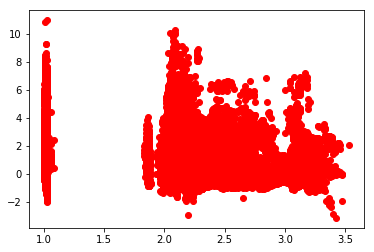

In [444]:
plt.plot(tst["dist"], tst["scalar_coupling_constant"],  'ro')

In [445]:
tst = df_train.copy()

In [446]:
tst.groupby('type')["id"].agg('count')

type
1JHC    709418 
1JHN    43363  
2JHC    1140677
2JHH    378036 
2JHN    119253 
3JHC    1510381
3JHH    590611 
3JHN    166415 
Name: id, dtype: int64

In [449]:
def get_new_types(tst):
    tst['type_new'] = np.where(np.logical_and(tst['type'] == '1JHC', tst['dist'] < 1.065), '1JHC1', 
                               np.where(np.logical_and(tst['type'] == '1JHC', tst['dist'] > 1.065), '1JHC2',
                                        np.where(np.logical_and(tst['type'] == '2JHN', tst['dist'] < 1.2), '2JHN1',
                                                np.where(np.logical_and(tst['type'] == '2JHN', tst['dist'] > 1.2), '2JHN2',
                                                        np.where(np.logical_and(tst['type'] == '2JHC', tst['dist'] < 1.2), '2JHC1',
                                                                np.where(np.logical_and(tst['type'] == '2JHC', tst['dist'] > 1.2), '2JHC2',
                                                                         np.where(np.logical_and(tst['type'] == '3JHH', tst['dist'] < 1.3), '3JHH1',
                                                                                  np.where(np.logical_and(tst['type'] == '3JHH', tst['dist'] > 1.3), '3JHH2',
                                                                                          np.where(np.logical_and(tst['type'] == '3JHC', tst['dist'] < 1.4), '3JHC1',
                                                                                                   np.where(np.logical_and(tst['type'] == '3JHC', tst['dist'] > 1.4), '3JHC2',
                                                                                                           np.where(np.logical_and(tst['type'] == '3JHN', tst['dist'] < 1.4), '3JHN1',
                                                                                                                   np.where(np.logical_and(tst['type'] == '3JHN', tst['dist'] > 1.4), '3JHN2',
                                                                                                                            tst['type']))))))))))))
    return(tst)

In [456]:
df_train_new = get_new_types(full_train)
df_test_new = get_new_types(full_test)

In [457]:
df_train_new.groupby('type_new')["id"].agg('count')

type_new
1JHC1    9260   
1JHC2    700158 
1JHN     43363  
2JHC1    763290 
2JHC2    377387 
2JHH     378036 
2JHN1    35870  
2JHN2    83383  
3JHC1    1131204
3JHC2    379177 
3JHH1    572096 
3JHH2    18515  
3JHN1    63610  
3JHN2    102805 
Name: id, dtype: int64

In [458]:
df_test_new.groupby('type_new')["id"].agg('count')

type_new
1JHC1    4857  
1JHC2    375752
1JHN     24195 
2JHC1    409580
2JHC2    203558
2JHH     203126
2JHN1    19643 
2JHN2    44781 
3JHC1    606577
3JHC2    205422
3JHH1    307567
3JHH2    9868  
3JHN1    34882 
3JHN2    55734 
Name: id, dtype: int64

In [ ]:
def show_varimp(fit_model, model_type, mol_type, X, base_path):
        if not os.path.exists(f'{base_path}/varImp/{model_type}'):
            os.makedirs(f'{base_path}/varImp/{model_type}')
        
        feature_imp = pd.DataFrame(sorted(zip(fit_model.feature_importances_,X.columns)), columns=['Value','Feature'])
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title(f'LightGBM Features of {model_type} Model')
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{base_path}/varImp/{model_type}/variable_importances_{mol_type}.png')
        varimps = pd.DataFrame(feature_imp.sort_values(by="Value", ascending=False))
        varimps.to_csv(f'{base_path}/varImp/{model_type}/variable_importances_{mol_type}.csv', index = False)

In [ ]:
# Model LightGBM Params
random_state = 513
np.random.seed(random_state)

params = {'num_leaves': 128,
          'min_child_samples': 50,
          'min_data_in_leaf' : 20,  
          'objective': 'huber',
          'n_estimators': 30000,
          'max_depth': 9,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": random_state,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0,
          "seed": random_state
         }

K = 10
kf = KFold(n_splits = K, random_state = 1, shuffle = True)

In [ ]:


def train_model(df_train, df_test, base_path, model_type = None, params = None, gridParams = None):
        print(f'{model_type} will be trained ...')
        dict_score = dict()
        submission_list = list()
        for moltype in df_train['type'].unique():
            varImp = pd.read_csv(f'{base_path}/varImp/{model_type}/variable_importances_{moltype}.csv')
            varImp = varImp[varImp.Value >= 100]
            varImpCount = varImp["Feature"].nunique() 
            varImpUnique = list(varImp['Feature'].unique())
            varImpUnique.extend(['id', 'molecule_index', 'scalar_coupling_constant', 'type'])

            df_train_type = df_train[df_train.type == moltype].reset_index(drop = True)
            df_train_type = df_train_type[varImpUnique]

            varImpUnique.remove('scalar_coupling_constant')

            df_test_type = df_test[df_test.type == moltype].reset_index(drop = True)
            df_test_type = df_test_type[varImpUnique]

            print(f'{varImpCount} features have been chosen for modeling of the {moltype} type')

            df_train_type = df_train_type.drop(['type'],  axis=1)
            df_test_type = df_test_type.drop(['type'],  axis=1)
            X = df_train_type.drop(['id', 'molecule_index', 'scalar_coupling_constant'], axis=1)
            Y = df_train_type['scalar_coupling_constant']
            X_test = df_test_type.drop(['id', 'molecule_index'], axis=1)
            print(moltype)
#             print(f'Hyper parameter optimization for {moltype} starts...')

#             mdl = lgb.LGBMRegressor(**params)

#             grid = GridSearchCV(estimator = mdl, 
#                                 param_grid = gridParams,
#                                 scoring='neg_mean_absolute_error',
#                                 verbose=50,
#                                 cv=2,
#                                 n_jobs=30)

#             grid.fit(X, Y)

#             maxdep = grid.best_params_["max_depth"]
#             learnrate = grid.best_params_["learning_rate"]
            
#             # Print the best parameters found
#             print(f' the best max_depth is {maxdep} and the best learning rate of {learnrate}')
#             print(f'the best score is {grid.best_score_}')

#             params['max_depth'] = grid.best_params_['max_depth']
#             params['learning_rate'] = grid.best_params_['learning_rate']

#             print(f'Hyper parameter optimization for {moltype} is finished. Model tarining starts')

#             gc.collect()      
            submit_pred = np.zeros(X_test.shape[0])
            scores = []
            for i, (train_index, test_index) in enumerate(kf.split(df_train_type)):

                # Create data for this fold
                Y_train, Y_valid = Y.iloc[train_index].copy(), Y.iloc[test_index].copy()
                X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()

                print( f'\nFold {moltype}: {i}')
            
                if model_type == 'LGBM':
                    fit_model = lgb.LGBMRegressor(**params)
                    fit_model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
                                  eval_metric='mae', verbose=100, early_stopping_rounds=200)
                
                elif model_type == 'CatBoost':
                    fit_model = cat.CatBoostRegressor(**params)                                                    
                    fit_model.fit(X_train, Y_train,  verbose = False)
                else : 
                    print(f'This {model_type} is not yet supported!')
                
                pred = fit_model.predict(X_valid)
                # Save validation predictions for this fold
                print( "Group Log MAE: ", math.log(mean_absolute_error(Y_valid, pred)))
                scores.append(math.log(mean_absolute_error(Y_valid, pred)))
                
                # Predict on Test data set
                submit_pred += fit_model.predict(X_test) / K
                

            print(f'The mean score of a model for {moltype} is: {np.mean(scores)}')
            dict_score[moltype] = np.mean(scores)

            #submit_pred = fit_model.predict(X_test)
            submit_pred= pd.DataFrame(submit_pred)
            submit_pred.columns = ['scalar_coupling_constant']
            sub = pd.concat([df_test_type['id'], submit_pred], axis = 1)
            submission_list.append(sub)
            # Show variable importance of a model
            #show_varimp(fit_model = fit_model, model_type = model_type, mol_type = moltype, X = X, base_path = SUBMISSIONS_PATH)

        print("Overall mean is ", np.array(list(dict_score.values())).mean())
        return [submission_list, dict_score]
    

In [ ]:
import gc
gc.collect()

In [ ]:
submission_list = train_model(df_train = full_train, 
                              df_test = full_test, base_path = SUBMISSIONS_PATH, model_type = 'LGBM', params = params)

In [ ]:
full_train.head()

In [90]:
#train_csv[train_csv['type'] == "1JHN"].head()

,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant,scalar_coupling_constant_pred
id,,,,,,
10,2,1,0,1JHN,32.688900,35.150242
13,2,2,0,1JHN,32.689098,35.150242
15,2,3,0,1JHN,32.690498,35.148834
97,12,3,0,1JHN,55.525200,55.608601
101,12,4,0,1JHN,54.735901,55.006992


In [76]:
#test_csv[test_csv['type'] == "1JHN"].head()

,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant_pred
id,,,,,
4658203,20,4,0,1JHN,48.790562
4658207,20,5,0,1JHN,51.765114
4658212,20,6,2,1JHN,48.788555
4658216,20,7,2,1JHN,51.765625
4658303,36,7,1,1JHN,55.876621


In [77]:
#### Second Model ####

In [29]:
#old = pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})
#old
submission_list[1]

{'1JHC': -0.6526732124668086,
 '2JHH': -2.0181248389774744,
 '1JHN': -1.1669335277189563,
 '2JHN': -2.012644432326053,
 '2JHC': -1.5958350804223742,
 '3JHH': -1.9813504070416905,
 '3JHC': -1.5174514453309664,
 '3JHN': -2.212257527268629}

In [55]:
#new = pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})
#new

,type,cv_score
0,1JHN,-1.053029
1,1JHC,-0.447551
2,2JHH,-1.921464
3,2JHN,-2.060994
4,2JHC,-1.457819
5,3JHH,-1.980045
6,3JHC,-1.366661
7,3JHN,-2.293368


In [31]:
#old_score =np.mean(list(cv_scores.values()))
#old_score

-1.4729154767544388

In [56]:
#new_score = np.mean(list(cv_scores.values()))
#new_score

-1.5726163903722918

In [60]:
#submission[submission['scalar_coupling_constant'] == 0].shape

(0, 1)

In [61]:
#submission.head(10)

,scalar_coupling_constant
id,
4658147,20.722425
4658148,149.625244
4658149,9.406529
4658150,149.625244
4658151,20.722425
4658152,92.152794
4658153,2.612074
4658154,-7.505294
4658155,-9.595772


In [30]:
final_submit = pd.concat(submission_list[0])

In [31]:
final_submit.head()

,id,scalar_coupling_constant
0,4658148,186.631179
1,4658150,185.957946
2,4658152,90.090494
3,4658156,90.058673
4,4658159,82.768923


In [32]:
print("Overall mean is ", np.array(list(submission_list[1].values())).mean())

Overall mean is  -1.644658808944119


In [33]:
final_submit.to_csv('my_features_and_criskiev_features_15000_est.csv', index = False)

In [62]:
#submission.to_csv(f'{SUBMISSIONS_PATH}/submission_criskiev_20000est_5fold.csv')

In [34]:
!kaggle competitions submit -c champs-scalar-coupling -f my_features_and_criskiev_features_15000_est.csv -m "my lgb and features from criskiev 15000 est and 10 folds"

100%|██████████████████████████████████████| 64.0M/64.0M [00:04<00:00, 13.5MB/s]
Successfully submitted to Predicting Molecular Properties